In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from numpy import pi, cosh, exp, round, zeros, identity, arange, real, cos, sin, multiply, outer, flip
from numpy.fft import fft,ifft, fftfreq, fft2, ifft2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch

import numpy as np  # Import numpy
import math
from numpy.linalg import inv, norm

# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.collections import LineCollection
# from numpy import pi, cosh, exp, flip, zeros, identity, arange, real, cos, sin, multiply, outer, transpose
# from numpy.fft import fft,ifft, fftfreq, fft2, ifft2
# from matplotlib.pyplot import figure

# import numpy as np  # Import numpy
# import math
# from numpy.linalg import inv

In [27]:


# given a 2d field u_vec = [u, v] on xc, yc in the physical space
# filter out divergent part to make del . u_vec = 0
# using Helmholtz decomposition

# The code is written on the transformed co-ordinates xc x yc = [0, 2\pi) x [0, 2\pi)
# Physical coordinates [0, Lx] x [0, Ly]


def filter_div(u, v):
    L = 2*pi
    [Ny, Nx] = np.shape(u)

    # flip from matrix indexing to cartesian indexing do fft stuff
    u = (flip((u), axis=0))
    v = (flip((v), axis=0))
    alpha = 0 # 1e-10 # regularization parameter
    uHat = fft2(u)
    vHat = fft2(v)

    dx = L/(Nx)
    dy = L/(Ny)
    
    # see test_fft2.py to see how k's are arranged in python3
    kx = fftfreq(Nx, d = dx)*(2*pi)
    ky = fftfreq(Ny, d = dy)*(2*pi)
    kx[Nx//2] = 0.
    ky[Ny//2] = 0.
    # print("kx", kx)
    # KX, KY = np.meshgrid(kx, ky, indexing='ij')
    KX, KY = np.meshgrid(kx, ky)
    K2 = KX**2 + KY**2

    # divuHat = - Hat{(del.u_vec)}
    divuHat = -1j*(KX*uHat + KY*vHat)
    print("max(divu) = ", np.max(abs(np.real(ifft2(divuHat)))))

    # filter_ = 1.0/ (-KX**2 - KY**2 + alpha**2)
    # filter_[K2 == 0] = 0.
    # phiHat = divuHat*filter_
    phiHat = zeros(np.shape(divuHat), dtype=complex)

    # now everything is in cartesian indexing, ii for x, jj for y now
    for ii in range(0, Nx):
        for jj in range(0, Ny):
            k = KX[ii, jj]
            l = KY[ii, jj]

            if(k == 0 and l == 0):
                phiHat[ii, jj] = 0. # phase fixing condition, zero mean condition
            else:
                phiHat[ii, jj] = divuHat[ii, jj]/(-k**2 - l**2 + alpha**2)

    # du0_vec = grad phi => {du0Hat, dv0Hat} = {1j*k*phiHat, 1j*l*phiHat}
    du0Hat = 1j*KX*phiHat
    dv0Hat = 1j*KY*phiHat

    # method 1: if flipping
    du0 = real(ifft2(du0Hat)) # probably need scaling factor for ifft2
    # print("max(du0) = ", np.max(abs(u0)))
    # return to original matrix indexing
    du0 = (flip((du0), axis=0))
    u = flip((u), axis=0)
    u0 = du0 + u

    dv0 = real(ifft2(dv0Hat))
    # return to original matrix indexing
    dv0 = (flip((dv0), axis=0))
    v = flip((v), axis=0)
    v0 = dv0 + v
    

    return u0, v0

In [3]:

# # load data


# u = torch.load('./filter/vel_x.pt')
# v = torch.load('./filter/vel_y.pt')

# u = u[0,0,:,:]
# v = v[0,0,:,:]

# u = np.array(u)
# v = np.array(v)

# [Ny, Nx] = np.shape(u)

# kx = fftfreq(Nx, d = dx) * coeff
# ky = fftfreq(Ny, d = dy) * coeff

# # KY, KX = np.meshgrid(ky, kx)
# kx[Nx//2] = 0.
# ky[Ny//2] = 0.
# KX, KY = np.meshgrid(kx, ky) # if flipping

# # kx = zeros(Nx);
# # kx[0:Nx//2] = arange(0, Nx//2); kx[Nx//2+1:] = arange(-Nx//2+1, 0, 1);
# # ky = zeros(Ny);
# # ky[0:Ny//2] = arange(0, Ny//2); ky[Ny//2+1:] = arange(-Ny//2+1, 0, 1);

# [u_final , v_final, u0, v0] = filter_div(u, v)

# u0Hat = fft2(u0)
# v0Hat = fft2(v0)
# divu0 = zeros((Ny, Nx))
# divu0Hat = zeros((Ny, Nx), dtype=complex)
# for ii in range(0, Ny):
#     for jj in range(0, Nx):
#         k = kx[jj]
#         l = ky[ii]
#         divu0Hat[ii, jj] = 1j*k*u0Hat[ii, jj] + 1j*l*v0Hat[ii, jj]

# divu0 = real(ifft2(divu0Hat))

# # print("max(max(divu0))", max(max(divu0)))



In [4]:
# load data
n_train = 10
T = 5

# TRAIN_PATH = '/home/atif/datasets/dpsl_Re1e4_dx_256/dpsl_data_N5000_T201_ux_uy_vort.h5'
# f = h5py.File(TRAIN_PATH, 'r')

# u = torch.tensor(f['vel_x'][0:n_train,0:T,:,:]).type(torch.float32)
# v = torch.tensor(f['vel_y'][0:n_train,0:T,:,:]).type(torch.float32)
# u = torch.load('./filter/vel_x.pt')
# v = torch.load('./filter/vel_y.pt')

x = np.linspace(0,2*np.pi,100)
y = np.linspace(0,2*np.pi,100)

X,Y = meshgrid(x,y)


u = u[0,0,:,:]
v = v[0,0,:,:]

u = np.array(u)
v = np.array(v)
print(f'{np.shape(u)}')

[Ny, Nx] = np.shape(u)

L = 2*pi
dx = L/(Nx)
dy = L/(Ny)
coeff = (2*pi)

kx = fftfreq(Nx, d =dx) * coeff
ky = fftfreq(Ny, d =dy) * coeff

kx[Nx//2] = 0.
ky[Ny//2] = 0.

KX, KY = np.meshgrid(kx, ky)

[u_fin, v_fin, du0, dv0] = filter_div(u, v)

u0 = du0
v0 = dv0

u = (flip((u), axis=0))
v = (flip((v), axis=0))
u0 = (flip((u0), axis=0))
v0 = (flip((v0), axis=0))

uHat = fft2(u)
vHat = fft2(v)
u0Hat = fft2(u0)
v0Hat = fft2(v0)
divu0 = zeros((Ny, Nx))
divu0Hat = zeros((Ny, Nx), dtype=complex)
vort0Hat = zeros((Ny, Nx), dtype=complex)
vortHat = zeros((Ny, Nx), dtype=complex)
vortFD = zeros((Ny, Nx))

vortHat = 1j*(KX*vHat - KY*uHat)
divu0Hat = 1j*(KX*uHat + KY*vHat)
vort0Hat = 1j*(KX*v0Hat - KY*u0Hat)

vort = (real(ifft2(vortHat)))
divu0 = (real(ifft2(divu0Hat)))
vort0 = (real(ifft2(vortHat)))

# original matrix indexing
vort = ((flip((vort), axis=0)))
divu0 = ((flip((divu0), axis=0)))
vort0 = ((flip((vort0), axis=0)))

# return to original matrix indexing
u = flip((u), axis=0)
v = flip((v), axis=0)

# now calculate vortFD with original matrix indexing
for ii in range(1, Ny-1):
    for jj in range(1, Nx-1):
        vortFD[ii, jj]   = (v[ii,jj+1] - v[ii,jj-1]) - (u[ii-1,jj] - u[ii+1,jj])
        # vortFD[ii, jj]   = (v[ii+1,jj] - v[ii-1,jj]) - (u[ii,jj+1] - u[ii,jj-1])

print("max(max(divu0))", np.max(abs(divu0)))

###########################################

for index in range(0,1):
    
    # Plotting a sample vorticity heat map
    #vortmax = (np.max(vortFD))
    #vortmin = (np.min(vortFD))
    #umax = (torch.max(u))
    #umin = (torch.min(u))
    #vmax = (torch.max(v))
    #vmin = (torch.min(v))
     
    fig, axs = plt.subplots()
    
    for a in range (0,1):
        ax2 = fig.add_subplot(1,3,a+1)
        im  = ax2.imshow(torch.from_numpy(vortFD[:,:]), cmap='bwr', interpolation='nearest')
        #im  = ax2.imshow(torch.from_numpy(u0[:,:]), vmin=umin, vmax=umax, cmap='bwr', interpolation='nearest')
        #im  = ax2.imshow(u[index,a,:,:].cpu(), vmin=umin, vmax=umax, cmap='bwr', interpolation='nearest')
        plt.axis('off')
        ax2.set_xticks([])
        ax2.set_yticks([])
    
        ax2 = fig.add_subplot(1,3,a+2)
        im  = ax2.imshow(torch.from_numpy(vort.copy()), cmap='bwr', interpolation='nearest')
        #im  = ax2.imshow(torch.from_numpy(v0[:,:]), vmin=vmin, vmax=vmax, cmap='bwr', interpolation='nearest')
        #im  = ax2.imshow(v[index,a,:,:].cpu(), vmin=vmin, vmax=vmax, cmap='bwr', interpolation='nearest')
        plt.axis('off')
        ax2.set_xticks([])
        ax2.set_yticks([])

        ax2 = fig.add_subplot(1,3,a+3)
        im  = ax2.imshow(torch.from_numpy(vort0.copy()), cmap='bwr', interpolation='nearest')
        #im  = ax2.imshow(torch.from_numpy(v0[:,:]), vmin=vmin, vmax=vmax, cmap='bwr', interpolation='nearest')
        #im  = ax2.imshow(v[index,a,:,:].cpu(), vmin=vmin, vmax=vmax, cmap='bwr', interpolation='nearest')
        plt.axis('off')
        ax2.set_xticks([])
        ax2.set_yticks([])
    
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.86, 0.15, 0.01, 0.7])
    cbar_ax.tick_params(labelsize=20)
    fig.colorbar(im,cax=cbar_ax)
    plt.show()
    
    # fig.savefig(f'test_{index}_3d_channels_uv.png')
    # plt.close()


###########################################
# compare KE
KE_uv = 0.5*(u*u + v*v)
KE_filtered_uv = 0.5*(u0*u0 + v0*v0)

print("norm(KE(u, v)) = ", norm(KE_uv) )
print("norm(KE(u0, v0)) = ", norm(KE_filtered_uv) )

###########################################
# compare enstrophy

print("abs(enstrophy(u, v)) = ", norm(vort*vort) )
print("abs(enstrophy(u0, v0)) = ", norm(vort0*vort0) )

###########################################

NameError: name 'meshgrid' is not defined

In [ ]:
print(x)

[0.         0.06346652 0.12693304 0.19039955 0.25386607 0.31733259
 0.38079911 0.44426563 0.50773215 0.57119866 0.63466518 0.6981317
 0.76159822 0.82506474 0.88853126 0.95199777 1.01546429 1.07893081
 1.14239733 1.20586385 1.26933037 1.33279688 1.3962634  1.45972992
 1.52319644 1.58666296 1.65012947 1.71359599 1.77706251 1.84052903
 1.90399555 1.96746207 2.03092858 2.0943951  2.15786162 2.22132814
 2.28479466 2.34826118 2.41172769 2.47519421 2.53866073 2.60212725
 2.66559377 2.72906028 2.7925268  2.85599332 2.91945984 2.98292636
 3.04639288 3.10985939 3.17332591 3.23679243 3.30025895 3.36372547
 3.42719199 3.4906585  3.55412502 3.61759154 3.68105806 3.74452458
 3.8079911  3.87145761 3.93492413 3.99839065 4.06185717 4.12532369
 4.1887902  4.25225672 4.31572324 4.37918976 4.44265628 4.5061228
 4.56958931 4.63305583 4.69652235 4.75998887 4.82345539 4.88692191
 4.95038842 5.01385494 5.07732146 5.14078798 5.2042545  5.26772102
 5.33118753 5.39465405 5.45812057 5.52158709 5.58505361 5.648520

In [32]:
def div_and_curl_FD(x,y,u,v):
    # Compute the partial derivatives
    du_dx, du_dy = np.gradient(u, x, y)
    dv_dx, dv_dy = np.gradient(v, x, y)

    # Compute divergence
    div = du_dx + dv_dy

    # Compute curl
    curl = dv_dx - du_dy

    return div, curl


def div_and_curl_spectral(u,v):
    # X,Y = np.meshgrid(x,y)

    L = 2*pi
    [Nx, Ny] = np.shape(u)

    dx = L/Nx
    dy = L/Ny

    kx = fftfreq(Nx, d=dx)* (2 * pi)
    ky = fftfreq(Ny, d=dy)* (2 * pi)
    kx[Nx//2] = 0.
    ky[Ny//2] = 0.

    KX, KY = np.meshgrid(kx, ky)

    uHat = fft2(u)
    vHat = fft2(v)

    vortHat = 1j*(KX*vHat - KY*uHat)
    vort = np.real(ifft2(vortHat))

    divuHat = 1j*(KX*uHat + KY*vHat)
    div = np.real(ifft2(divuHat))

    return div, vort



div_FD  = 0.024538764687037598
curl_FD = 127.9461974974981
div_spec  = 4.4144137461054866e-13
curl_spec = 128.00000000000003


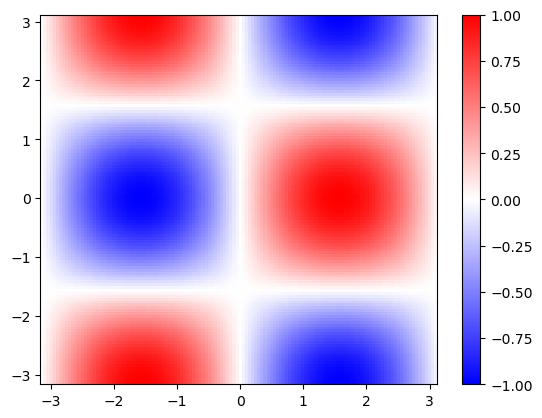

In [23]:
Lx = 2*pi
Ly = 2*pi

N = 128
dx = Lx/(N)
dy = Ly/(N)

x = np.arange(-Lx/2,Lx/2,dx)
y = np.arange(-Ly/2,Ly/2,dy)

X,Y = np.meshgrid(x,y)

u = np.sin(X)*np.cos(Y)
v = -np.cos(X)*np.sin(Y)

# omega = 1.0
# u =  omega*np.sqrt(X*X + Y*Y)*sin(np.arctan(Y/X))
# v = -omega*np.sqrt(X*X + Y*Y)*cos(np.arctan(Y/X))

# u = omega*sin(np.arctan(Y/X))
# v = -omega*cos(np.arctan(Y/X))

div_FD, curl_FD     = div_and_curl_FD(x,y,u,v)
div_spec, curl_spec = div_and_curl_spectral(u,v)

print(f'div_FD  = {np.max(div_FD)}')
print(f'curl_FD = {np.linalg.norm(curl_FD)}')

print(f'div_spec  = {np.max(div_spec)}')
print(f'curl_spec = {np.linalg.norm(curl_spec)}')

fig, ax = plt.subplots()
# ax = fig.add_subplot()
im = ax.pcolormesh(x,y,u,cmap='bwr')
fig.colorbar(im, ax=ax)
plt.show()


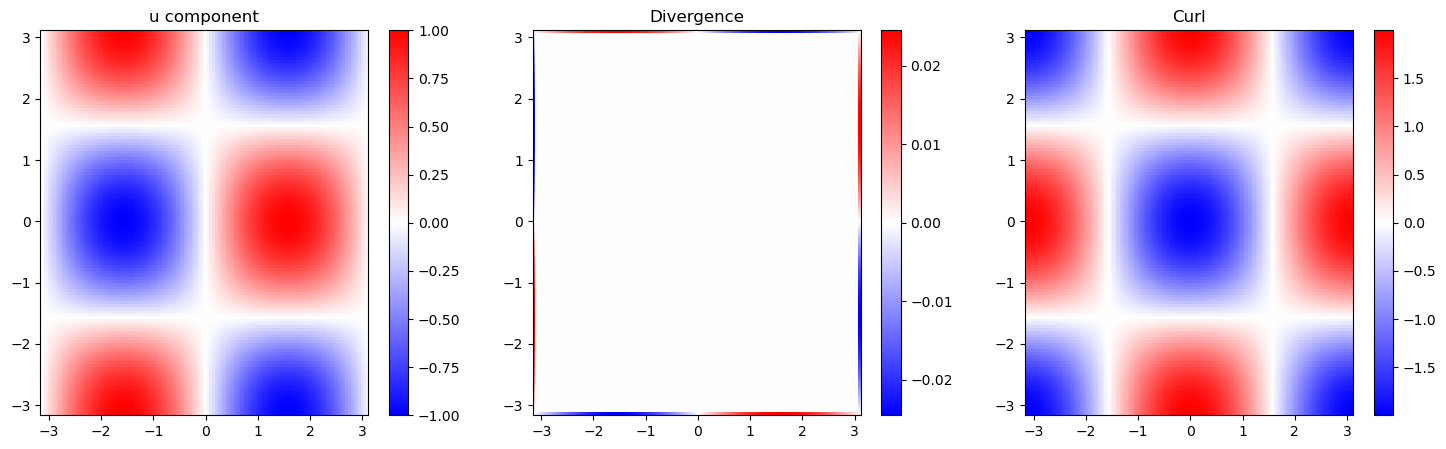

In [24]:
# Plot the original vector field, divergence, and curl
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im_u = ax[0].pcolormesh(x, y, u, cmap='bwr')
ax[0].set_title('u component')
fig.colorbar(im_u, ax=ax[0])

# Plot divergence
im_div = ax[1].pcolormesh(x, y, div_FD, cmap='bwr')
ax[1].set_title('Divergence')
fig.colorbar(im_div, ax=ax[1])

# Plot curl
im_curl = ax[2].pcolormesh(x, y, curl_FD, cmap='bwr')
ax[2].set_title('Curl')
fig.colorbar(im_curl, ax=ax[2])

plt.show()

1.2725028459034273
0.9094807361344626
1.5765264845278115
div_spec  = 2.3976811170677585
curl_spec = 77.25748557205006


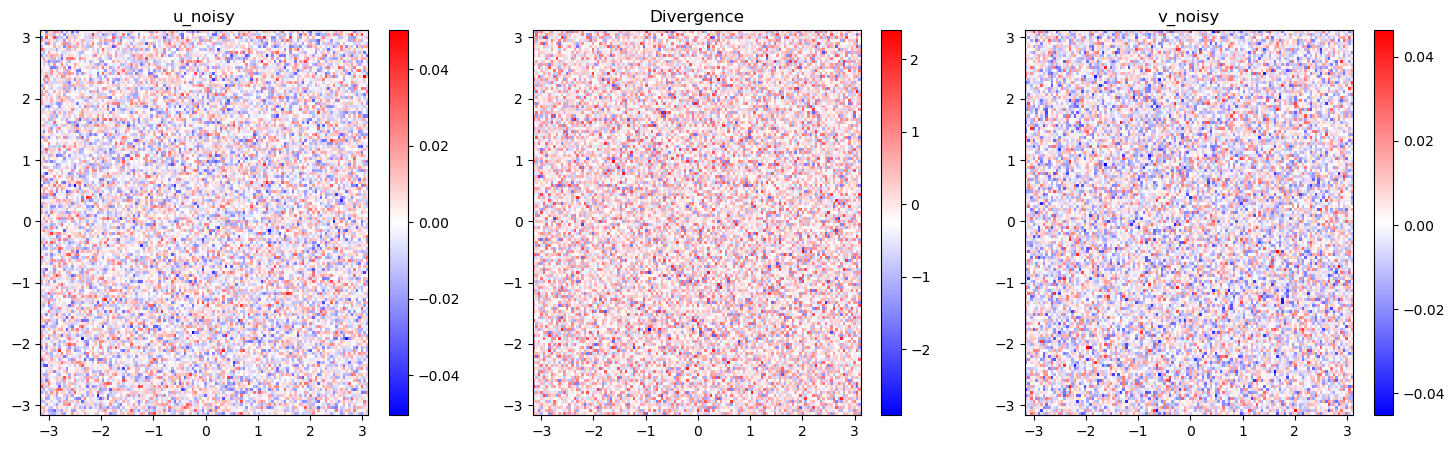

In [31]:
# Generate Gaussian noise
mean = 0
std_dev = 0.01
u_noise = np.random.normal(mean, std_dev, u.shape)
v_noise = np.random.normal(mean, std_dev, u.shape)

print(np.linalg.norm(noise))

u_noisy = u + u_noise
v_noisy = v + v_noise

print(np.linalg.norm(u))
print(np.linalg.norm(u_noisy))

div_spec, curl_spec = div_and_curl_spectral(u_noisy,v_noisy)

print(f'div_spec  = {np.max(div_spec)}')
print(f'curl_spec = {np.linalg.norm(curl_spec)}')

# Plot the original vector field, divergence, and curl
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im_u = ax[0].pcolormesh(x, y, u_noisy, cmap='bwr')
ax[0].set_title('u_noisy')
fig.colorbar(im_u, ax=ax[0])

# Plot divergence
im_div = ax[1].pcolormesh(x, y, div_spec, cmap='bwr')
ax[1].set_title('Divergence')
fig.colorbar(im_div, ax=ax[1])

# Plot curl
im_curl = ax[2].pcolormesh(x, y, v_noisy, cmap='bwr')
ax[2].set_title('v_noisy')
fig.colorbar(im_curl, ax=ax[2])

plt.show()



max(divu) =  3.296782256895045


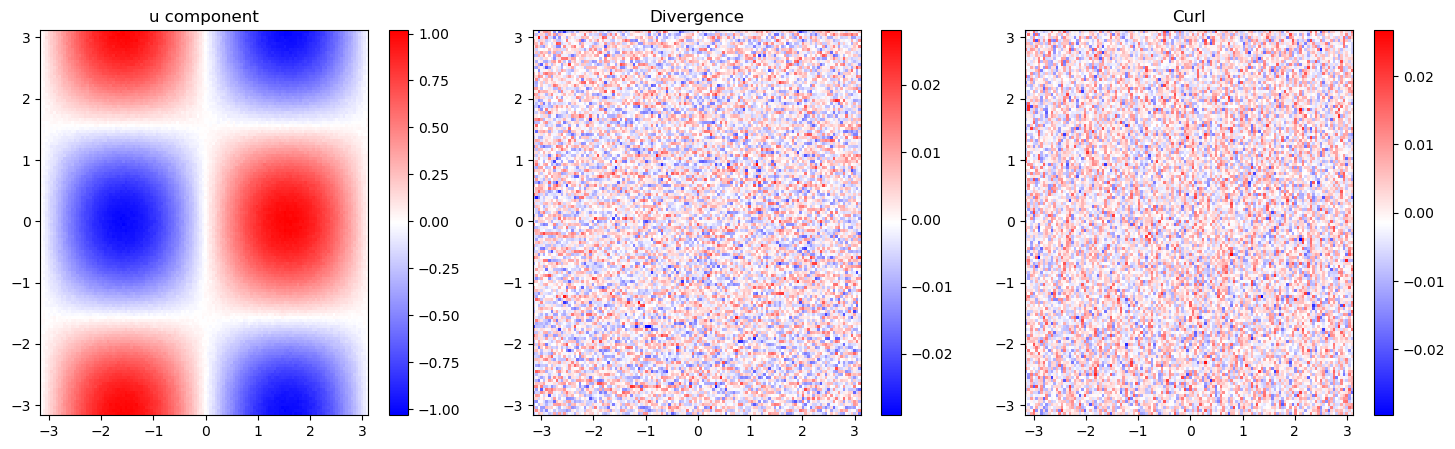

In [30]:
u,v = filter_div(u_noisy, v_noisy)

# Plot the original vector field, divergence, and curl
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im_u = ax[0].pcolormesh(x, y, u_noisy, cmap='bwr')
ax[0].set_title('u component')
fig.colorbar(im_u, ax=ax[0])

# Plot divergence
im_div = ax[1].pcolormesh(x, y, u, cmap='bwr')
ax[1].set_title('Divergence')
fig.colorbar(im_div, ax=ax[1])

# Plot curl
im_curl = ax[2].pcolormesh(x, y, v, cmap='bwr')
ax[2].set_title('Curl')
fig.colorbar(im_curl, ax=ax[2])

plt.show()